Multinomial Naive Bayes is a classification algorithm for discrete data and is typically used in text classification problems.

In [277]:
#!pip install pyro-ppl
#!pip install transformers

In [278]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

In [279]:
import pandas as pd

# Load the TSV files
df_train = pd.read_csv("train.tsv", sep='\t')
df_test = pd.read_csv("test.tsv", sep='\t')
df_valid = pd.read_csv("valid.tsv", sep='\t')

# Show first few rows
print(df_train.head())

    2635.json        false  \
0  10540.json    half-true   
1    324.json  mostly-true   
2   1123.json        false   
3   9028.json    half-true   
4  12465.json         true   

  Says the Annies List political group supports third-trimester abortions on demand.  \
0  When did the decline of coal start? It started...                                   
1  Hillary Clinton agrees with John McCain "by vo...                                   
2  Health care reform legislation is likely to ma...                                   
3  The economic turnaround started at the end of ...                                   
4  The Chicago Bears have had more starting quart...                                   

                             abortion    dwayne-bohac  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   charlie-crist   
4    

In [280]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   2635.json                                                                           10239 non-null  object 
 1   false                                                                               10239 non-null  object 
 2   Says the Annies List political group supports third-trimester abortions on demand.  10239 non-null  object 
 3   abortion                                                                            10237 non-null  object 
 4   dwayne-bohac                                                                        10237 non-null  object 
 5   State representative                                                                7341 non-nu

In [281]:
# View the column names to identify the text and label columns
print(df_train.columns)

Index(['2635.json', 'false',
       'Says the Annies List political group supports third-trimester abortions on demand.',
       'abortion', 'dwayne-bohac', 'State representative', 'Texas',
       'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'],
      dtype='object')


In [282]:
def load_and_preprocess(path):
    columns = [
        'id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    label_map = {'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}
    df['label'] = df['label'].map(label_map)
    metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
    df[metadata_cols] = df[metadata_cols].fillna('unknown')
    return df

train_df = load_and_preprocess('train.tsv')
valid_df = load_and_preprocess('valid.tsv')
test_df = load_and_preprocess('test.tsv')

In [283]:
train_df

,id,label,statement,subject,speaker,job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,unknown,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,4,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,unknown,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,4,Democrats have now become the party of the [At...,elections,alan-powell,unknown,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,3,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,unknown,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,unknown,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [284]:
metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
label_encoders = {}
for col in metadata_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], valid_df[col], test_df[col]])
    le.fit(combined)
    label_encoders[col] = le
    for df in [train_df, valid_df, test_df]:
        df[col + '_enc'] = le.transform(df[col])

In [285]:
credit_cols = [
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts']
for df in [train_df, valid_df, test_df]:
    df[credit_cols] = df[credit_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

In [286]:
df.head()

,id,label,statement,subject,speaker,job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,speaker_enc,job_enc,state_enc,party_enc,context_enc
0,11972.json,5,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,2646,453,62,20,266
1,11685.json,1,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,1756,993,79,6,1641
2,11096.json,1,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,871,790,42,20,4157
3,5209.json,3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,2658,1172,48,20,1964
4,9524.json,0,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,unknown,Wisconsin,democrat,5,7,2,2,7,a web video,2902,1344,79,6,2871


In [287]:
df.columns

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state',
       'party', 'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_on_fire_counts', 'context', 'speaker_enc',
       'job_enc', 'state_enc', 'party_enc', 'context_enc'],
      dtype='object')

In [288]:
df.describe()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,speaker_enc,job_enc,state_enc,party_enc,context_enc
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,2.740331,11.770324,13.465667,17.566693,16.912391,6.016575,1581.857143,896.019732,50.340174,14.643252,2315.307814
std,1.545408,18.980496,23.956307,36.109290,36.499879,15.059981,949.603394,394.695170,27.029157,6.328972,1366.433613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,811.500000,581.000000,22.000000,6.000000,1191.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1582.000000,970.000000,51.000000,17.000000,2111.000000
75%,4.000000,12.000000,17.000000,15.000000,14.000000,6.000000,2442.500000,1344.000000,79.000000,20.000000,3314.000000
max,5.000000,70.000000,114.000000,160.000000,163.000000,105.000000,3304.000000,1354.000000,84.000000,22.000000,5136.000000


In [289]:
df.shape

(1267, 19)

In [290]:
# Splitting features and target from df 
X = df.drop('label', axis = 1)
y = df['label']

# shapes
print(X.shape)
print(y.shape)

(1267, 18)
(1267,)


In [291]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Splitting into training, testing, and val
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Shape and size of train, test and val dataset
print('X train shape {}'.format(X_train.shape))
print('X test shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test shape {}'.format(y_test.shape))
print('X val shape {}'.format(X_val.shape))
print('y val shape {}'.format(y_val.shape))

X train shape (810, 18)
X test shape (254, 18)
y train shape (810,)
y test shape (254,)
X val shape (203, 18)
y val shape (203,)


In [292]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Vectorize Text (TF-IDF)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['statement'])
X_val = vectorizer.transform(valid_df['statement'])

# Labels
y_train = train_df['label']
y_val = valid_df['label']

# Fit the model
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [293]:
# Predict and evaluate
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.23286604361370716


In [294]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on validation set
y_pred = model.predict(X_val)

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.23286604361370716

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.28      0.30      0.29       263
           2       0.22      0.05      0.08       237
           3       0.21      0.52      0.30       248
           4       0.25      0.29      0.27       251
           5       0.21      0.04      0.07       169

    accuracy                           0.23      1284
   macro avg       0.19      0.20      0.17      1284
weighted avg       0.21      0.23      0.19      1284



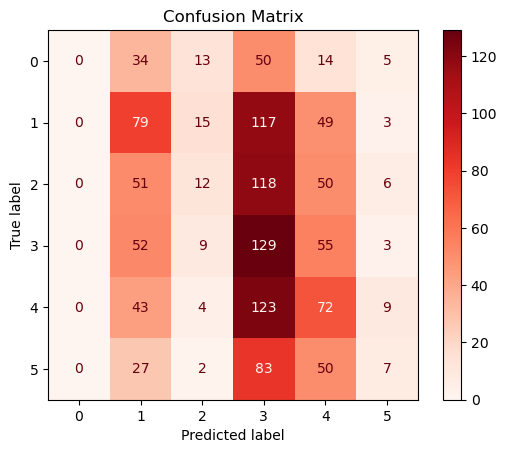

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Reds')
plt.title("Confusion Matrix")
plt.show()


In [296]:
# Check each column's predictive value individually.
for col in ['statement','speaker', 'job', 'state', 'party', 'context']:
    X_train_col = vectorizer.fit_transform(train_df[col].fillna(''))
    X_val_col = vectorizer.transform(valid_df[col].fillna(''))
    model.fit(X_train_col, y_train)
    print(f"{col} Accuracy:", accuracy_score(y_val, model.predict(X_val_col)))


statement Accuracy: 0.23286604361370716
speaker Accuracy: 0.24766355140186916
job Accuracy: 0.22897196261682243
state Accuracy: 0.21105919003115264
party Accuracy: 0.22897196261682243
context Accuracy: 0.21884735202492211


In [297]:
# Combined metadata columns 
train_df['combined_text'] = (
    train_df['statement'].fillna('') + ' ' +
    train_df['speaker'].fillna('') + ' ' +
    train_df['job'].fillna('') + ' ' +
    train_df['state'].fillna('') + ' ' +
    train_df['party'].fillna('') + ' ' +
    train_df['context'].fillna('')
)

valid_df['combined_text'] = (
    valid_df['statement'].fillna('') + ' ' +
    valid_df['speaker'].fillna('') + ' ' +
    valid_df['job'].fillna('') + ' ' +
    valid_df['state'].fillna('') + ' ' +
    valid_df['party'].fillna('') + ' ' +
    valid_df['context'].fillna('')
)

# Vectorize Text (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_text = vectorizer.fit_transform(train_df['combined_text'])
X_val_text = vectorizer.transform(valid_df['combined_text'])


In [298]:
# Fit the model
nb_model = MultinomialNB()
nb_model.fit(X_train_text, y_train)

MultinomialNB()

In [299]:
# Predict and evaluate
y_pred_2 = nb_model.predict(X_val_text)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_2))

Validation Accuracy: 0.26246105919003115


In [300]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on validation set
y_pred_2 = nb_model.predict(X_val_text)

# Accuracy
acc_2 = accuracy_score(y_val, y_pred_2)
print("Combined Text Accuracy:", acc_2)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_2))

Combined Text Accuracy: 0.26246105919003115

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.09      0.15       116
           1       0.28      0.38      0.32       263
           2       0.22      0.08      0.12       237
           3       0.24      0.45      0.31       248
           4       0.30      0.30      0.30       251
           5       0.22      0.12      0.15       169

    accuracy                           0.26      1284
   macro avg       0.29      0.24      0.23      1284
weighted avg       0.28      0.26      0.24      1284



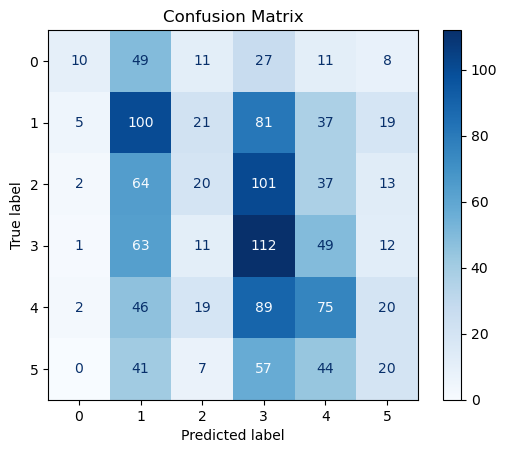

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [302]:
import pandas as pd

# Combine train and validation sets
final_train_df = pd.concat([train_df, valid_df], axis=0)
final_X_text = final_train_df['combined_text']
final_y = final_train_df['label']  

In [303]:
# Combine metadata columns for test set
test_df['combined_text'] = (
    test_df['statement'].fillna('') + ' ' +
    test_df['speaker'].fillna('') + ' ' +
    test_df['job'].fillna('') + ' ' +
    test_df['state'].fillna('') + ' ' +
    test_df['party'].fillna('') + ' ' +
    test_df['context'].fillna('')
)

In [304]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize Text (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_final_train = vectorizer.fit_transform(final_X_text)
X_test = vectorizer.transform(test_df['combined_text'])

Train the Final Model

In [305]:
from sklearn.naive_bayes import MultinomialNB
# Train model
final_model = MultinomialNB()
final_model.fit(X_final_train, final_y)


MultinomialNB()

In [306]:
# Evaluate on Test Set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_test = test_df['label'] 
y_pred_test = final_model.predict(X_test)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


Test Accuracy: 0.26992896606156275

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.08      0.13        92
           1       0.28      0.39      0.33       249
           2       0.28      0.11      0.16       212
           3       0.27      0.45      0.33       265
           4       0.22      0.27      0.25       241
           5       0.34      0.15      0.21       208

    accuracy                           0.27      1267
   macro avg       0.30      0.24      0.23      1267
weighted avg       0.29      0.27      0.25      1267



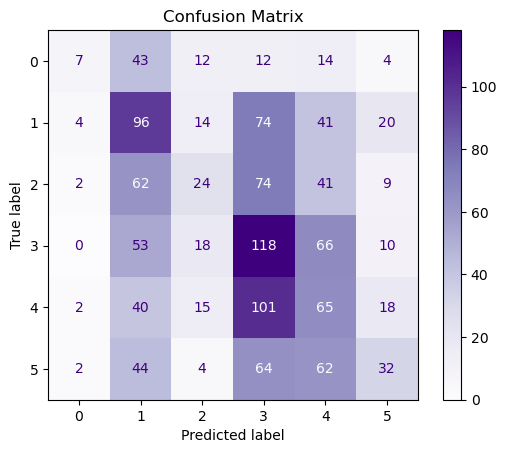

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Purples')
plt.title("Confusion Matrix")
plt.show()